In [1]:
from google.colab import drive 
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
#drive.flush_and_unmount(timeout_ms=24)

In [3]:

import numpy as np
import pandas as pd
import pickle
import numpy as np
import random
import time
import os
#os.environ["OPENCV_IO_MAX_IMAGE_PIXELS"] = pow(2,40).__str__()
import cv2
from tqdm import tqdm

import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from keras import optimizers
#from sklearn.metrics import classification_report, confusion_matrix
import sklearn
import seaborn as sn
from keras.callbacks import CSVLogger, LambdaCallback
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
csv_file = "drive/My Drive/Caltech256 Dataset/caltech256.csv"
df_original = pd.read_csv(csv_file) # , delimiter = " ", header=None
#train_df_original.columns = ['Column_1', 'filename', 'label', 'Column_2']
df_original.head()

,Unnamed: 0,fold,label,path
0,0,1,0,001.ak47/001_0001.jpg
1,1,1,0,001.ak47/001_0002.jpg
2,2,1,0,001.ak47/001_0003.jpg
3,3,1,0,001.ak47/001_0004.jpg
4,4,1,0,001.ak47/001_0005.jpg


In [5]:
df_full_path = df_original

for i in range(df_original.shape[0]):
    filename = df_original['path'][i]
    file_full_path = f"drive/My Drive/Caltech256 Dataset/256_ObjectCategories/256_ObjectCategories/{filename}"
    df_full_path['path'][i] = file_full_path
    
print(f"df_full_path['path'][0] = {df_full_path['path'][0]}")
df_full_path.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


df_full_path['path'][0] = drive/My Drive/Caltech256 Dataset/256_ObjectCategories/256_ObjectCategories/001.ak47/001_0001.jpg


,Unnamed: 0,fold,label,path
0,0,1,0,drive/My Drive/Caltech256 Dataset/256_ObjectCa...
1,1,1,0,drive/My Drive/Caltech256 Dataset/256_ObjectCa...
2,2,1,0,drive/My Drive/Caltech256 Dataset/256_ObjectCa...
3,3,1,0,drive/My Drive/Caltech256 Dataset/256_ObjectCa...
4,4,1,0,drive/My Drive/Caltech256 Dataset/256_ObjectCa...


In [6]:
df_full_path['label'] = df_full_path['label'].astype(str)

In [7]:
k = 1 # 5-folds
train_df = df_full_path[df_full_path['fold'] != k]
print(f"train_df.shape = {train_df.shape}")
train_df.head()

train_df.shape = (24385, 4)


,Unnamed: 0,fold,label,path
20,20,2,0,drive/My Drive/Caltech256 Dataset/256_ObjectCa...
21,21,2,0,drive/My Drive/Caltech256 Dataset/256_ObjectCa...
22,22,2,0,drive/My Drive/Caltech256 Dataset/256_ObjectCa...
23,23,2,0,drive/My Drive/Caltech256 Dataset/256_ObjectCa...
24,24,2,0,drive/My Drive/Caltech256 Dataset/256_ObjectCa...


In [8]:
'''
train_df_1 = pd.DataFrame(np.array(train_df), columns=train_df.columns.values)
train_df_1.head()
#'''

'\ntrain_df_1 = pd.DataFrame(np.array(train_df), columns=train_df.columns.values)\ntrain_df_1.head()\n#'

In [9]:
test_df = df_full_path[df_full_path['fold']==k]
print(f"test_df.shape = {test_df.shape}")
test_df.tail()

test_df.shape = (6222, 4)


,Unnamed: 0,fold,label,path
29941,29941,1,256,drive/My Drive/Caltech256 Dataset/256_ObjectCa...
29942,29942,1,256,drive/My Drive/Caltech256 Dataset/256_ObjectCa...
29943,29943,1,256,drive/My Drive/Caltech256 Dataset/256_ObjectCa...
29944,29944,1,256,drive/My Drive/Caltech256 Dataset/256_ObjectCa...
29945,29945,1,256,drive/My Drive/Caltech256 Dataset/256_ObjectCa...


In [10]:
'''
test_df_1 = pd.DataFrame(np.array(test_df), columns=test_df.columns.values)
test_df_1.head()
#'''

'\ntest_df_1 = pd.DataFrame(np.array(test_df), columns=test_df.columns.values)\ntest_df_1.head()\n#'

In [11]:
Dataset_Name = f"Caltech256_Kaggle_5_folds_k{str(k)}"
work_dir = "drive/My Drive/Caltech256 Dataset/Records/"

color_type = 'rgb' # rgb, grayscale
BATCH_SIZE = 16

In [12]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [13]:
train_generator = train_datagen.flow_from_dataframe(
        train_df,
        directory=None,
        x_col='path', 
        y_col='label',
        #target_size=(800, 804),  # target images are automatically resized to (256, 256)
        batch_size=BATCH_SIZE,
        shuffle = True,
        color_mode=color_type, # grayscale, rgb
        class_mode='categorical' # categorical, raw
        )

Found 24385 validated image filenames belonging to 257 classes.


In [14]:
num_classes = len(train_generator.class_indices)
total_train_data = train_generator.samples

print(f"total_train_data = {total_train_data}")
print(f"train_generator.image_shape = {train_generator.image_shape}")
print(f"num_classes = {num_classes}")

total_train_data = 24385
train_generator.image_shape = (256, 256, 3)
num_classes = 257


In [15]:
test_generator = test_datagen.flow_from_dataframe(
        test_df,
        directory=None,
        x_col='path', 
        y_col='label',
        #target_size=(800, 804),  # target images are automatically resized to (256, 256)
        batch_size=BATCH_SIZE,
        shuffle = False,
        color_mode=color_type, # grayscale, rgb
        class_mode='categorical')

Found 6222 validated image filenames belonging to 257 classes.


In [16]:
total_test_data = test_generator.samples
print(f"total_test_data = {total_test_data}")

total_test_data = 6222


In [17]:
# DenseNet121 ResNet101 ResNet50 DenseNet201 InceptionV3 Xception NASNetLarge ResNet152V2 InceptionResNetV2 EfficientNetB7
impl_type = "TransferLearning3D.DenseNet201" # TransferLearning3D 
dataset = f"{Dataset_Name}.{color_type}.{train_generator.image_shape[:2]}.DataFlow" # +str(img_size)+"p"
dataset

'Caltech256_Kaggle_5_folds_k1.rgb.(256, 256).DataFlow'

In [18]:
#'''
count_no_improvement = 0
epoch_initial = True
#'''

In [19]:
#NUM_NEURONS = 16
#NUM_LAYERS = 3
#BATCH_SIZE = 16 # 10
NUM_EPOCHS = 5 # 300
epochs_completed = 0
LEARNING_RATE = 0.00001
EPSILON = 1e-4
early_stop_after_epochs = 5
DROPOUT = 0.5 # 0.5 0.0
pad = 0

LOSS = 'categorical_crossentropy'
ACTIVATION_FUNCTION = 'elu' # relu sigmoid elu
FINAL_ACTIVATION_FUNCTION = 'softmax'
validation_split = 0.1
kernel_size=(1,1)
pointTrainableAfter = "allDefault" # "allDefault" 160 170
OPTIMIZER = "Adam" # Adam SGD RMSProp
init_weights = "imagenet" # "imagenet" None
modelExt = ".Dense.1024.1024.2048" # .Dense.128.256.512, .512.512.512 .Dense.512.512.512.512.Res
l2_val = 0.001

# +"_kernel"+str(kernel_size)+"_lr"+str(LEARNING_RATE)+"_batch"+str(BATCH_SIZE)+"_epochs"+str(NUM_EPOCHS)
#checkpointer_name  = "weights_"+dataset+"_"+impl_type+"_nLayers"+str(NUM_LAYERS)+"_nNeurons"+str(NUM_NEURONS)+".hdf5"
ext = f".Flatten.l2.{str(l2_val)}.run_1" # run_1 run_2 .DropAfter .momentum0.9
#'''
checkpointer_name  = "weights."+dataset+".pad"+str(pad)+"."+impl_type+".wInit."+str(init_weights)+".TrainableAfter."+str(pointTrainableAfter)+\
                     modelExt+".actF."+ACTIVATION_FUNCTION+".opt."+OPTIMIZER+".drop."+str(DROPOUT)+".batch"+str(BATCH_SIZE)+ext+".hdf5"
log_name = "log."+checkpointer_name[8:-5]+".log"

print('checkpointer_name =', checkpointer_name)
print('log_name =', log_name)
#'''

checkpointer_name = weights.Caltech256_Kaggle_5_folds_k1.rgb.(256, 256).DataFlow.pad0.TransferLearning3D.DenseNet201.wInit.imagenet.TrainableAfter.allDefault.Dense.1024.1024.2048.actF.elu.opt.Adam.drop.0.5.batch16.Flatten.l2.0.001.run_1.hdf5
log_name = log.Caltech256_Kaggle_5_folds_k1.rgb.(256, 256).DataFlow.pad0.TransferLearning3D.DenseNet201.wInit.imagenet.TrainableAfter.allDefault.Dense.1024.1024.2048.actF.elu.opt.Adam.drop.0.5.batch16.Flatten.l2.0.001.run_1.log


In [20]:
train_generator.image_shape

(256, 256, 3)

In [21]:
#'''
#base_model=DenseNet121(weights=None, include_top=False, input_shape=np_train_dataset2.shape[1:]) # `None` (random initialization)
#base_model=ResNet152V2(weights=None, include_top=False, input_shape=np_train_dataset2.shape[1:])
# ResNet152V2 ResNet50 ResNet101 ResNet152 DenseNet201 InceptionV3 Xception NASNetLarge 'imagenet' ResNet152V2 DenseNet121
#inputs = Input(final_train_imageset.shape[1:])
#x = ZeroPadding2D(padding=(pad,pad))(inputs)
#base_model=tf.keras.applications.ResNet50(weights=init_weights, include_top=False, input_tensor=x)
base_model=tf.keras.applications.DenseNet201(weights=init_weights, include_top=False, input_shape=train_generator.image_shape)
x=base_model.output

x = Flatten()(x)

#'''
x = Dense(1024, kernel_regularizer=tf.keras.regularizers.l2(l2_val), activation=ACTIVATION_FUNCTION)(x)
#x_copy = x
x = Dropout(DROPOUT)(x)
x = Dense(1024, kernel_regularizer=tf.keras.regularizers.l2(l2_val), activation=ACTIVATION_FUNCTION)(x)
x = Dropout(DROPOUT)(x)
x = Dense(2048, kernel_regularizer=tf.keras.regularizers.l2(l2_val), activation=ACTIVATION_FUNCTION)(x)
x = Dropout(DROPOUT)(x)
#x = Add()([x,x_copy])
#'''
outputs=Dense(num_classes,activation='softmax')(x)

model=Model(inputs=base_model.input,outputs=outputs)
model.summary()
#'''

74842112/74836368 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 128, 128, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1/conv[0][0]                 
_____________________________

In [22]:
'''
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=True, dpi=64
)
#'''

"\ntf.keras.utils.plot_model(\n    model, to_file='model.png', show_shapes=True, show_dtype=False,\n    show_layer_names=True, rankdir='TB', expand_nested=True, dpi=64\n)\n#"

In [23]:
count_trainable = 0
count_non_trainable = 0

#'''
if pointTrainableAfter == "allDefault":
    for layer in model.layers:
        layer.trainable=True
        count_trainable += 1
elif pointTrainableAfter > 0:
    for layer in model.layers[:pointTrainableAfter]: # [:-pointTrainableAfter]
        layer.trainable=False
        count_non_trainable += 1
    for layer in model.layers[pointTrainableAfter:]: # [-pointTrainableAfter:]
        layer.trainable=True
        count_trainable += 1
#'''

'''
for layer in model.layers:
    layer.trainable=True
    count_trainable += 1
#'''

print("count_non_trainable =", count_non_trainable)
print("count_trainable =", count_trainable)
print("Total number of layers =", count_non_trainable+count_trainable)

count_non_trainable = 0
count_trainable = 715
Total number of layers = 715


In [24]:
'''
checkpointer_name  = "weights."+dataset+".pad"+str(pad)+"."+impl_type+".wInit."+str(init_weights)+".TrainableAfter."+str(pointTrainableAfter)+\
                     modelExt+".opt."+OPTIMIZER+".drop."+str(DROPOUT)+".batch"+str(BATCH_SIZE)+ext+".hdf5"
log_name = "log."+checkpointer_name[8:-5]+".log"

print('checkpointer_name =', checkpointer_name)
print('log_name =', log_name)
#'''

'\ncheckpointer_name  = "weights."+dataset+".pad"+str(pad)+"."+impl_type+".wInit."+str(init_weights)+".TrainableAfter."+str(pointTrainableAfter)+                     modelExt+".opt."+OPTIMIZER+".drop."+str(DROPOUT)+".batch"+str(BATCH_SIZE)+ext+".hdf5"\nlog_name = "log."+checkpointer_name[8:-5]+".log"\n\nprint(\'checkpointer_name =\', checkpointer_name)\nprint(\'log_name =\', log_name)\n#'

In [25]:
# "RMSProp" "SGD" "Adam" "Adamax" "Adadelta" "Adagrad" "SGD"
#optimizer = tf.keras.optimizers.RMSprop(lr = LEARNING_RATE, epsilon=EPSILON)

if OPTIMIZER == "RMSProp":
    optimizer = tf.keras.optimizers.RMSprop(lr = LEARNING_RATE, epsilon=EPSILON)
elif OPTIMIZER == "Adam":
    optimizer = tf.keras.optimizers.Adam(lr = LEARNING_RATE, epsilon=EPSILON, beta_1=0.9, beta_2=0.999)
elif OPTIMIZER == "Adamax":
    optimizer = tf.keras.optimizers.Adamax(lr = LEARNING_RATE, epsilon=EPSILON, beta_1=0.9, beta_2=0.999)
elif OPTIMIZER == "Adadelta":
    optimizer = tf.keras.optimizers.Adadelta(lr = LEARNING_RATE, epsilon=EPSILON, rho=0.95)
elif OPTIMIZER == "Adagrad":
    optimizer = tf.keras.optimizers.Adagrad(lr = LEARNING_RATE, epsilon=EPSILON, initial_accumulator_value=0.1)
elif OPTIMIZER == "SGD":
    optimizer = tf.keras.optimizers.SGD(lr = LEARNING_RATE, momentum=0.9)

model.compile(
    #optimizer=OPTIMIZER,
    optimizer=optimizer,
    loss=LOSS,
    metrics=['accuracy']
)

print("OPTIMIZER =", OPTIMIZER)

OPTIMIZER = Adam


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [26]:
# save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath = work_dir+checkpointer_name, 
                               #monitor='val_accuracy',
                               monitor='val_loss',
                               save_weights_only=False,  
                               mode='auto', 
                               verbose = 1, # 0 = silent, 1 = progress bar, 2 = one line per epoch
                               save_best_only =False
                               )
checkpointer_best = ModelCheckpoint(filepath = work_dir+"best_"+checkpointer_name, 
                                    monitor='val_loss', 
                                    save_weights_only=False,
                                    mode='auto',  
                                    verbose = 1, 
                                    save_best_only = True
                                    )
early_stopping = EarlyStopping(monitor='loss', patience=early_stop_after_epochs)

In [27]:
'''
if 'count_no_improvement' not in globals():
    count_no_improvement = 0
    print("count_no_improvement =", count_no_improvement)
#'''
'''
count_no_improvement = 0
epoch_initial = False
#'''
min_delta = 0.0009
print("count_no_improvement =", count_no_improvement)

def checkBestPerformance(epoch, logs):
    save_filepath = work_dir+"best_"+checkpointer_name

    global epoch_initial
    if epoch_initial == True:
        epoch_initial = False
        model.save(filepath = save_filepath)
        print(". Model saved!")

    elif epoch_initial == False:
        global count_no_improvement

        log_data = pd.read_csv(work_dir+log_name, sep=',', usecols=['val_loss', 'val_accuracy'], engine='python')
        min_val_loss = float(str(min(log_data.val_loss.values))[:6])
        max_val_acc = float(str(max(log_data.val_accuracy.values))[:6])

        current_val_acc = float(str(logs['val_accuracy'])[:6])
        current_val_loss = float(str(logs['val_loss'])[:6])

        if (current_val_loss < min_val_loss) and (abs(current_val_loss-min_val_loss) >= min_delta):
            count_no_improvement = 0
            model.save(filepath = save_filepath)
            print("\nval_loss decreased from",min_val_loss," to",current_val_loss,"( val_accuracy =",current_val_acc,").")

        elif (current_val_loss==min_val_loss) and (current_val_acc>max_val_acc):
            count_no_improvement = 0
            model.save(filepath = save_filepath)
            print("\nval_accuracy increased to", current_val_acc, ".")

        else:
            count_no_improvement += 1
            print(". count_no_improvement =", count_no_improvement)

        if count_no_improvement >= early_stop_after_epochs:
            global list_callbacks
            del list_callbacks, count_no_improvement
            #print("count_no_improvement =", count_no_improvement, "... list_callbacks =", list_callbacks)

count_no_improvement = 0


In [28]:
epochs_completed = 0
list_callbacks = []
csv_logger = CSVLogger(work_dir+log_name, separator=',', append=True)

#if 'list_callbacks' in globals():
#    del list_callbacks

try:
    log_data = pd.read_csv(work_dir+log_name, sep=',', usecols=['epoch'], engine='python')
    epochs_completed = log_data.shape[0]

    #if epochs_completed > 0:
    model = load_model(work_dir+checkpointer_name)
    list_callbacks = [checkpointer, LambdaCallback(on_epoch_end=checkBestPerformance), csv_logger]
    print("epochs_completed =", epochs_completed)

except Exception as error:
    if epochs_completed == 0:
        # list_callbacks = [checkpointer, checkpointer_best, csv_logger, early_stopping] 
        list_callbacks = [checkpointer, LambdaCallback(on_epoch_end=checkBestPerformance), csv_logger]
        print("epochs_completed =", epochs_completed)
    elif epochs_completed > 0:
        print(error)

print('checkpointer_name =', checkpointer_name)

epochs_completed = 0
checkpointer_name = weights.Caltech256_Kaggle_5_folds_k1.rgb.(256, 256).DataFlow.pad0.TransferLearning3D.DenseNet201.wInit.imagenet.TrainableAfter.allDefault.Dense.1024.1024.2048.actF.elu.opt.Adam.drop.0.5.batch16.Flatten.l2.0.001.run_1.hdf5


In [29]:
print('checkpointer_name =', checkpointer_name)
print("Previously completed epochs =", epochs_completed)
print("count_no_improvement =", count_no_improvement, "\n")

#'''
try:
    start_time = time.time()
    history = model.fit(train_generator, 
                        steps_per_epoch=total_train_data // BATCH_SIZE,
                        shuffle=True, 
                        epochs = NUM_EPOCHS - epochs_completed, 
                        validation_data=test_generator,
                        validation_steps=total_test_data // BATCH_SIZE,
                        callbacks=list_callbacks
                        )
    elapsed_time = time.time() - start_time 
    print("\nTime elapsed: ", elapsed_time)

except Exception as error:
    print("\nError:", error)
#'''

checkpointer_name = weights.Caltech256_Kaggle_5_folds_k1.rgb.(256, 256).DataFlow.pad0.TransferLearning3D.DenseNet201.wInit.imagenet.TrainableAfter.allDefault.Dense.1024.1024.2048.actF.elu.opt.Adam.drop.0.5.batch16.Flatten.l2.0.001.run_1.hdf5
Previously completed epochs = 0
count_no_improvement = 0 

Epoch 1/300
1524/1524 [==============================] - 10561s 7s/step - loss: 9.3650 - accuracy: 0.1352 - val_loss: 6.2425 - val_accuracy: 0.6031

Epoch 00001: saving model to drive/My Drive/Caltech256 Dataset/Records/weights.Caltech256_Kaggle_5_folds_k1.rgb.(256, 256).DataFlow.pad0.TransferLearning3D.DenseNet201.wInit.imagenet.TrainableAfter.allDefault.Dense.1024.1024.2048.actF.elu.opt.Adam.drop.0.5.batch16.Flatten.l2.0.001.run_1.hdf5
. Model saved!
Epoch 2/300
1524/1524 [==============================] - 692s 453ms/step - loss: 6.8974 - accuracy: 0.3849 - val_loss: 4.7902 - val_accuracy: 0.7801

Epoch 00002: saving model to drive/My Drive/Caltech256 Dataset/Records/weights.Caltech256_Ka

KeyboardInterrupt: ignored

In [ ]:
# weights.Caltech256_Kaggle_5_folds_k1.rgb.(256, 256).DataFlow.pad0.TransferLearning3D.DenseNet201.wInit.imagenet.TrainableAfter.allDefault.Dense.1024.1024.2048.actF.elu.opt.Adam.drop.0.5.batch16.Flatten.l2.0.001.run_1.hdf5


In [ ]:
'''
Record: Caltech256_Kaggle_5_folds_k1_impl_1_256p_RGB_Dense201_Custom_withImageNet_DataFlow: (34.1%)
;
---

#'''

csv_logger = CSVLogger(work_dir+log_name, separator=',', append=True)
log_data = pd.read_csv(work_dir+log_name, sep=',', usecols=['epoch'], engine='python')
epochs_completed = log_data.shape[0]

result = model.evaluate(test_generator, steps=total_test_data // BATCH_SIZE)
print("Test Acc: {}, Test Loss: {}: ep{}, {}\n".format(round(result[1],4), round(result[0],4), epochs_completed, checkpointer_name))


In [30]:
#checkpointer_name = "weights.Fashion.DenseNet121.wInit.None.TrainableAfterallDefault.opt.SGD.drop.0.0.batch32.Flatten.run_1.hdf5"
model_loaded = load_model(work_dir+"best_"+checkpointer_name)
print("Loaded "+work_dir+"best_"+checkpointer_name+".")

Loaded drive/My Drive/Caltech256 Dataset/Records/best_weights.Caltech256_Kaggle_5_folds_k1.rgb.(256, 256).DataFlow.pad0.TransferLearning3D.DenseNet201.wInit.imagenet.TrainableAfter.allDefault.Dense.1024.1024.2048.actF.elu.opt.Adam.drop.0.5.batch16.Flatten.l2.0.001.run_1.hdf5.


In [31]:
'''
Record: Caltech256_Kaggle_5_folds_k1_impl_1_256p_RGB_Dense201_Custom_withImageNet_DataFlow: (34.1%)
;
---
Test Acc: 0.8623, Test Loss: 3.8825: ep0, best_weights.Caltech256_Kaggle_5_folds_k1.rgb.(256, 256).DataFlow.pad0.TransferLearning3D.DenseNet201.wInit.imagenet.TrainableAfter.allDefault.Dense.1024.1024.2048.actF.elu.opt.Adam.drop.0.5.batch16.Flatten.l2.0.001.run_1.hdf5

#'''
'''
csv_logger = CSVLogger(work_dir+log_name, separator=',', append=True)
log_data = pd.read_csv(work_dir+log_name, sep=',', usecols=['epoch'], engine='python')
epochs_completed = log_data.shape[0]
#'''

result2 = model_loaded.evaluate(test_generator, steps=total_test_data // BATCH_SIZE)
#print("nLayers: {}, nNeurons: {}, DROPOUT: {}, Test Acc: {}, Test Loss: {}".format(NUM_LAYERS, NUM_NEURONS, DROPOUT, round(result2[1], 4), round(result2[0], 4)))
print("Test Acc: {}, Test Loss: {}: ep{}, {}\n".format(round(result2[1],4), round(result2[0],4), epochs_completed, "best_"+checkpointer_name))


388/388 [==============================] - 51s 124ms/step - loss: 3.8825 - accuracy: 0.8623
Test Acc: 0.8623, Test Loss: 3.8825: ep0, best_weights.Caltech256_Kaggle_5_folds_k1.rgb.(256, 256).DataFlow.pad0.TransferLearning3D.DenseNet201.wInit.imagenet.TrainableAfter.allDefault.Dense.1024.1024.2048.actF.elu.opt.Adam.drop.0.5.batch16.Flatten.l2.0.001.run_1.hdf5



In [32]:
import csv

with open(work_dir+'Records.csv', "a") as fp:
    wr = csv.writer(fp, dialect='excel')
    try:
        wr.writerow([checkpointer_name[8:-5], round(result2[1], 4), round(result2[0], 4), elapsed_time])
    except:
        wr.writerow([checkpointer_name[8:-5], round(result2[1], 4), round(result2[0], 4)])
print("Saved results.")

Saved results.


In [33]:
#Confution Matrix and Classification Report
#'''
Y_pred = model_loaded.predict_generator(test_generator, verbose=1)
#'''
#'''
save_predictions_filename = f"Y_pred.{checkpointer_name[8:-5]}"
np.save(f"{work_dir}{save_predictions_filename}", Y_pred, allow_pickle=True)
print(f"Saved: {work_dir}{save_predictions_filename}")
#'''

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


389/389 [==============================] - 48s 117ms/step
Saved: drive/My Drive/Caltech256 Dataset/Records/Y_pred.Caltech256_Kaggle_5_folds_k1.rgb.(256, 256).DataFlow.pad0.TransferLearning3D.DenseNet201.wInit.imagenet.TrainableAfter.allDefault.Dense.1024.1024.2048.actF.elu.opt.Adam.drop.0.5.batch16.Flatten.l2.0.001.run_1


In [34]:
'''
save_predictions_filename = f"Y_pred.{checkpointer_name[8:-5]}"
np.save(f"{work_dir}{save_predictions_filename}", Y_pred, allow_pickle=True)
print(f"Saved: {work_dir}{save_predictions_filename}")
#'''

'\nsave_predictions_filename = f"Y_pred.{checkpointer_name[8:-5]}"\nnp.save(f"{work_dir}{save_predictions_filename}", Y_pred, allow_pickle=True)\nprint(f"Saved: {work_dir}{save_predictions_filename}")\n#'

In [35]:
#Y_pred_loaded = np.load(f"{work_dir}{save_predictions_filename_2}.npy", allow_pickle=True)
Y_pred_loaded = np.load(f"{work_dir}{save_predictions_filename}.npy", allow_pickle=True)
print(f"Y_pred_loaded.shape = {Y_pred_loaded.shape}")

Y_pred_loaded.shape = (6222, 257)


In [36]:
y_pred = np.argmax(Y_pred_loaded, axis=1)

In [37]:
y_true = test_generator.classes

In [38]:
list_class_names_in_generator = list(test_generator.class_indices.keys())
list_class_names_in_generator[:5]

['0', '1', '10', '100', '101']

In [39]:
len(list_class_names_in_generator)

257

In [40]:
list_y_true_rearranged = []
list_y_pred_rearranged = []

for true_class,pred_class in zip(y_true,y_pred):
    #print(f"true_class = {true_class}; pred_class = {pred_class}")
    #y_true_rearranged = int(list_class_names_in_generator[true_class][5:])
    #y_pred_rearranged = int(list_class_names_in_generator[pred_class][5:])

    y_true_rearranged = int(list_class_names_in_generator[true_class])
    y_pred_rearranged = int(list_class_names_in_generator[pred_class])

    list_y_true_rearranged.append(y_true_rearranged)
    list_y_pred_rearranged.append(y_pred_rearranged)

In [41]:
np_y_true_rearranged = np.array(list_y_true_rearranged)
np_y_pred_rearranged = np.array(list_y_pred_rearranged)

print(f"np_y_true_rearranged.shape = {np_y_true_rearranged.shape}")
print(f"np_y_pred_rearranged.shape = {np_y_pred_rearranged.shape}")
print(f"np_y_true_rearranged: {np_y_true_rearranged}")
print(f"np_y_pred_rearranged: {np_y_pred_rearranged}")

np_y_true_rearranged.shape = (6222,)
np_y_pred_rearranged.shape = (6222,)
np_y_true_rearranged: [  0   0   0 ... 256 256 256]
np_y_pred_rearranged: [  0   0   0 ... 244 256 256]


In [42]:
print(f"np_y_true_rearranged.shape = {np_y_true_rearranged.shape}\n")

index = -5
print(f"y_true[{index}:] = {y_true[index:]}")
print(f"y_pred[{index}:] = {y_pred[index:]}\n")
print(f"np_y_true_rearranged[{index}:] = {np_y_true_rearranged[index:]}")
print(f"np_y_pred_rearranged[{index}:] = {np_y_pred_rearranged[index:]}\n")
print(f"np.unique(np_y_true_rearranged) = {np.unique(np_y_true_rearranged)}")
print(f"np.unique(np_y_pred_rearranged) = {np.unique(np_y_pred_rearranged)}")

np_y_true_rearranged.shape = (6222,)

y_true[-5:] = [175, 175, 175, 175, 175]
y_pred[-5:] = [175 175 162 175 175]

np_y_true_rearranged[-5:] = [256 256 256 256 256]
np_y_pred_rearranged[-5:] = [256 256 244 256 256]

np.unique(np_y_true_rearranged) = [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184

In [43]:
conf_matrix = sklearn.metrics.confusion_matrix(np_y_true_rearranged, np_y_pred_rearranged)
print(f"Confusion Matrix:\n{conf_matrix}")

Confusion Matrix:
[[ 15   0   0 ...   0   0   0]
 [  0  19   0 ...   0   0   0]
 [  0   0  25 ...   0   0   0]
 ...
 [  0   0   0 ...   4   0   0]
 [  0   0   0 ...   0  21   0]
 [  0   1   0 ...   0   0 154]]


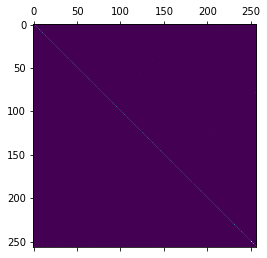

In [44]:
#plt.figure(figsize = (30,30))
plt.matshow(conf_matrix)

In [45]:
df_conf_matrix = pd.DataFrame(conf_matrix, index = [f"Class {i+1}" for i in range(num_classes)],
                  columns = [f"Class {i+1}" for i in range(num_classes)])

img_path = drive/My Drive/Caltech256 Dataset/Records/Images/conf_matrix_Caltech256_Kaggle_5_folds_k1.rgb.(256, 256).DataFlow.pad0.TransferLearning3D.DenseNet201.wInit.imagenet.TrainableAfter.allDefault.Dense.1024.1024.2048.actF.elu.opt.Adam.drop.0.5.batch16.Flatten.l2.0.001.run_1.png


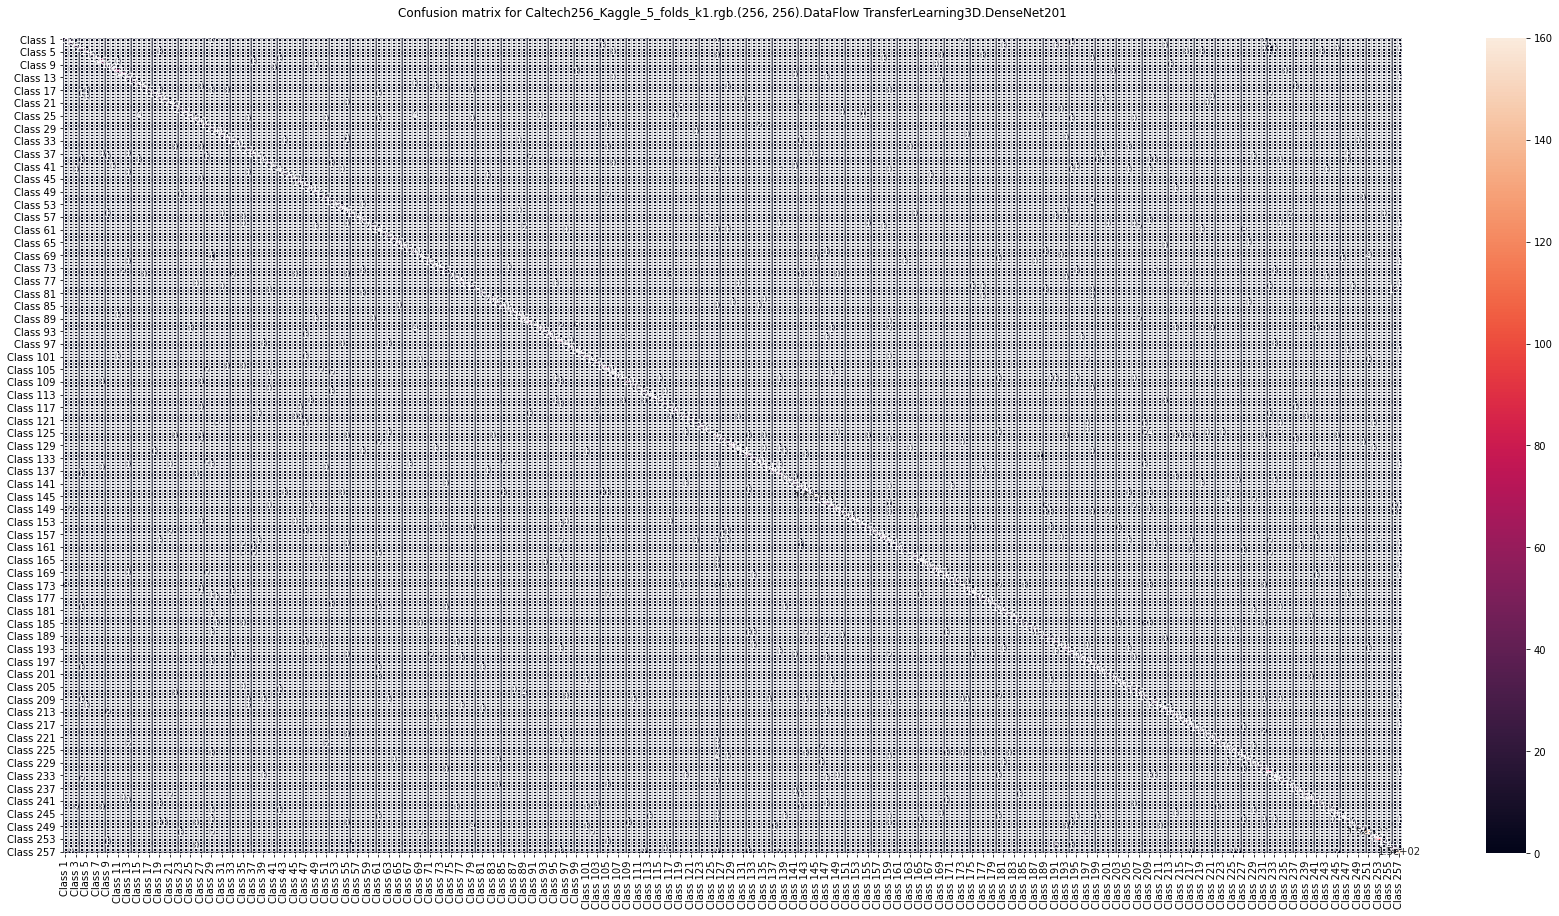

In [46]:
title = "Confusion matrix for "+dataset+" "+impl_type+"\n"
plt.figure(figsize = (30,15))
plt.title(title)
sn.heatmap(df_conf_matrix, annot=True)

img_path = work_dir+'Images/conf_matrix_'+checkpointer_name[8:-5]+'.png'
plt.savefig(img_path, dpi=600)
print(f"img_path = {img_path}")

In [47]:
#Confution Matrix and Classification Report
'''
Y_pred = model_loaded.predict_generator(final_test_imageset, len(final_test_imageset))
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(sklearn.metrics.confusion_matrix(np_test_label, y_pred))
#'''

"\nY_pred = model_loaded.predict_generator(final_test_imageset, len(final_test_imageset))\ny_pred = np.argmax(Y_pred, axis=1)\nprint('Confusion Matrix')\nprint(sklearn.metrics.confusion_matrix(np_test_label, y_pred))\n#"

In [48]:
# Precision [TP/TP+FP] = The ratio of correctly predicted positive observations to the total predicted positive observations.
# Recall (Sensitivity) [TP/TP+FN] = The ratio of correctly predicted positive observations to the all observations in actual class - 'yes'.
# F1 score [F1 Score = 2*(Recall * Precision) / (Recall + Precision)] = The weighted average of Precision and Recall.
# Support = The number of samples of the true response that lie in that class.
'''
print('Classification Report:')
print(sklearn.metrics.classification_report(test_generator.classes, y_pred))
#'''

"\nprint('Classification Report:')\nprint(sklearn.metrics.classification_report(test_generator.classes, y_pred))\n#"

In [49]:
test_generator.class_indices.keys()

dict_keys(['0', '1', '10', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '11', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '12', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '13', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '14', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '15', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '16', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '17', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '18', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '19', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199', '2', '20', '200', '201', '202', '203', '204', '205', '206', '207', '208', '209', '21', '210', '211', '212', '213', '214', '215', '216', '217', '218', '219', '22', '220', '221', '222', '223', '224', '225', '226', '227', 

In [50]:
#'''
print('Classification Report')
print(sklearn.metrics.classification_report(np_y_true_rearranged, np_y_pred_rearranged, target_names=test_generator.class_indices.keys()))
#'''

Classification Report
              precision    recall  f1-score   support

           0       0.83      0.75      0.79        20
           1       0.86      0.95      0.90        20
          10       0.89      0.81      0.85        31
         100       0.72      0.81      0.76        26
         101       0.89      0.80      0.84        30
         102       1.00      0.83      0.91        18
         103       1.00      0.86      0.93        22
         104       0.92      0.96      0.94        47
         105       0.78      0.86      0.82        21
         106       0.95      0.95      0.95        19
         107       0.95      0.95      0.95        56
         108       0.93      0.98      0.96        44
         109       0.68      0.85      0.76        20
          11       1.00      0.94      0.97        18
         110       0.83      0.96      0.89        25
         111       0.94      0.79      0.86        19
         112       1.00      0.71      0.83        21
     

In [51]:
log_data = pd.read_csv(work_dir+log_name, sep=',', engine='python') 

In [52]:
# Getting the model history keys 
#history.history.keys()
log_data.head()

,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.135213,9.365023,0.603093,6.242495
1,1,0.384874,6.897408,0.780122,4.790245
2,2,0.559686,5.604746,0.823776,4.304922
3,3,0.664984,4.893014,0.848905,4.025496
4,4,0.742460,4.429157,0.862274,3.882533


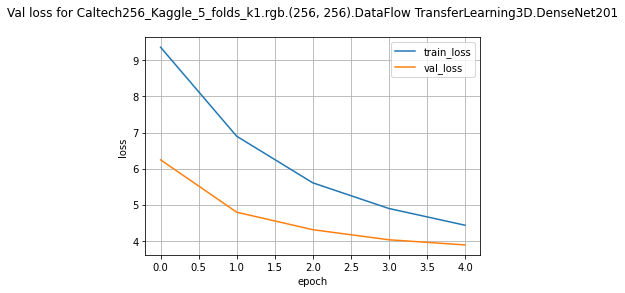

img_path = drive/My Drive/Caltech256 Dataset/Records/Images/vLoss_Caltech256_Kaggle_5_folds_k1.rgb.(256, 256).DataFlow.pad0.TransferLearning3D.DenseNet201.wInit.imagenet.TrainableAfter.allDefault.Dense.1024.1024.2048.actF.elu.opt.Adam.drop.0.5.batch16.Flatten.l2.0.001.run_1.png


In [53]:
# plot the training artifacts
title = "Val loss for "+dataset+" "+impl_type+"\n"

plt.plot(log_data['loss'])
plt.plot(log_data['val_loss'])
plt.title(title)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'], loc = 'best')
plt.grid(b=True, which='major', axis='both')

img_path = work_dir+'Images/vLoss_'+checkpointer_name[8:-5]+'.png'
plt.savefig(img_path, dpi=600)
plt.show()
print('img_path =', img_path)

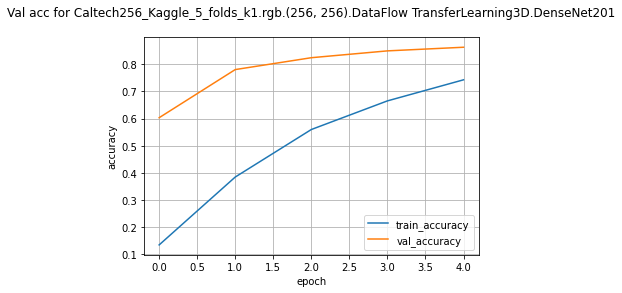

img_path = drive/My Drive/Caltech256 Dataset/Records/Images/vAcc_Caltech256_Kaggle_5_folds_k1.rgb.(256, 256).DataFlow.pad0.TransferLearning3D.DenseNet201.wInit.imagenet.TrainableAfter.allDefault.Dense.1024.1024.2048.actF.elu.opt.Adam.drop.0.5.batch16.Flatten.l2.0.001.run_1.png


In [54]:
title = "Val acc for "+dataset+" "+impl_type+"\n"

plt.plot(log_data['accuracy'])
plt.plot(log_data['val_accuracy'])
plt.title(title)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy','val_accuracy'], loc = 'best')
plt.grid(b=True, which='major', axis='both')

img_path = work_dir+'Images/vAcc_'+checkpointer_name[8:-5]+'.png'
plt.savefig(img_path, dpi=600)
plt.show()
print('img_path =', img_path)